In [1]:
import math
import random
import csv
import sys
import operator
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from shapely.geometry import Polygon, Point

import cvxpy as cp

import keras
from keras import layers
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.special import comb, perm
import time

In [2]:
# !pip install Ipython --upgrade
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Mount Google Drive Folder

In [3]:
from google.colab import drive, files
drive.mount('/content/drive')
rootPath = '/content/drive/Shareddrives/KW phase1 repo'

Mounted at /content/drive


In [4]:
import sys
sys.path.append(rootPath+'/package')
from utils.env_pca import env
from model.uav import UAV

## AE 

### Read Rawdata from csv



In [5]:
socpResultsDatas = []
div = 200
for j in range(env.N_ngps):
  with open(rootPath+"/datas/anomalyNewSDPResult/0817_PCA/test_position{}_pickerror0_deviation{}_100.csv".format(j,div), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    socpResultsDatas.append(csvReader)

### Read UAV Position

In [6]:
f = open(rootPath+"/datas/uavPosition/300_0706/done_deviation/{}/UAVsSamples.pkl".format(div), "rb")
UAVsSamples = pickle.load(f)
print(UAVsSamples)

{0: {0: <model.uav.UAV object at 0x7f93de628810>, 1: <model.uav.UAV object at 0x7f93dd555cd0>, 2: <model.uav.UAV object at 0x7f93dd555410>, 3: <model.uav.UAV object at 0x7f93dd555590>, 4: <model.uav.UAV object at 0x7f93dd555f10>, 5: <model.uav.UAV object at 0x7f93dd555c90>, 6: <model.uav.UAV object at 0x7f93dd555510>, 7: <model.uav.UAV object at 0x7f93dd555e50>, 8: <model.uav.UAV object at 0x7f93dd555c50>, 9: <model.uav.UAV object at 0x7f93dd5558d0>, 10: <model.uav.UAV object at 0x7f93dd5556d0>, 11: <model.uav.UAV object at 0x7f9460284a10>, 12: <model.uav.UAV object at 0x7f94602849d0>, 13: <model.uav.UAV object at 0x7f945b61dbd0>, 14: <model.uav.UAV object at 0x7f945b61db50>, 15: <model.uav.UAV object at 0x7f945b61d690>}, 1: {0: <model.uav.UAV object at 0x7f945b61d6d0>, 1: <model.uav.UAV object at 0x7f945b61d610>, 2: <model.uav.UAV object at 0x7f945b61d750>, 3: <model.uav.UAV object at 0x7f945b61d890>, 4: <model.uav.UAV object at 0x7f945b61d510>, 5: <model.uav.UAV object at 0x7f945b61d

In [7]:
assert(np.array(socpResultsDatas).shape[0] == env.N_ngps)
assert(np.array(socpResultsDatas).shape[2] == env.DIMENSION)
groupSize =0
for i in np.arange(env.groupSizeFrom,env.N_ngps+1,1):
  groupSize += comb(env.N_ngps,i)
groupSize = int(groupSize)
print(np.array(socpResultsDatas).shape)
assert(np.array(socpResultsDatas).shape[1]//env.SAMPLES == groupSize)

(8, 9300, 2)


### Loading sample from data

In [8]:
rawDatas = []
ReadSampleSize = env.LOAD_SAMPLES_FOR_AE
for i in range(env.N_ngps):
  temp = []
  for j in range(ReadSampleSize):
    temp.append(socpResultsDatas[i][j*groupSize : j*groupSize+groupSize])
  rawDatas.append(temp)

In [9]:
assert(np.array(rawDatas).shape[1] ==  env.LOAD_SAMPLES_FOR_AE)

In [10]:
_anchorSamples = []
anchorSamples = []
for sample in range(ReadSampleSize):
  temp = []
  for id, uav in UAVsSamples[sample].items():
    if not uav.observedPosition == None:
      temp.append([uav.observedPosition for i in range(groupSize)])
  _anchorSamples.append(temp)
for i in range(env.N_gps):
  temp = []
  for sample in range(ReadSampleSize):
    temp.append(_anchorSamples[sample][i])
  anchorSamples.append(temp)

In [11]:
# list(map(lambda i: rawDatas.append(anchorSamples[i]), range(env.N_gps)))
# None
# assert(np.array(rawDatas).shape[0] == env.N)

In [12]:
np.array(rawDatas).shape

(8, 100, 93, 2)

### Devide Test and Training set


In [13]:
testingSampleSize = int(( ReadSampleSize * env.TEST_PERCENTAGE )//1)
if testingSampleSize == 0:
  testingSampleSize = 1
traningSampleSize = int(ReadSampleSize-testingSampleSize)
rawTrainingData = list(map( lambda item: item[:-testingSampleSize], rawDatas))
rawTestingData =  list(map( lambda item: item[traningSampleSize:], rawDatas))

In [14]:
dualGroupingTrainingData = []
dualGroupingTestingData = []
def dualFunc(X,i,j): 
    temp = []
    for index_1, e1 in enumerate(X[i][j]):
      for index_2, e2 in enumerate(X[i][j]):
        if not index_1 == index_2:
          temp.append([e1, e2])
    return temp

rawTrainingDataShape = np.array(rawTrainingData).shape
rawTestingDataShape = np.array(rawTestingData).shape
for i in range(rawTrainingDataShape[0]):
  trainingS = list(map(lambda j: dualFunc(rawTrainingData,i,j),np.arange(0,rawTrainingDataShape[1])))
  testingS = list(map(lambda j: dualFunc(rawTestingData,i,j),np.arange(0,rawTestingDataShape[1])))
  dualGroupingTrainingData.append(trainingS)
  dualGroupingTestingData.append(testingS)

_trainingDataShape = np.array(dualGroupingTrainingData).shape
_testingDataShape= np.array(dualGroupingTestingData).shape
_reshapeTrainingData = []
_reshapeTestingData = []
def swapFunc(j,X,shapeOfX,targetReformSlice): 
  for sample in range(shapeOfX[1]): #sample
    temp = []
    for i in range(shapeOfX[0]):
      temp.append(X[i][sample][j])
    targetReformSlice.append(temp) 
list(map(lambda _sample: swapFunc(_sample,dualGroupingTrainingData,_trainingDataShape,_reshapeTrainingData), range(_trainingDataShape[2]))) #8556
list(map(lambda _sample: swapFunc(_sample,dualGroupingTestingData,_testingDataShape,_reshapeTestingData), range(_testingDataShape[2])))
print("")
VAETrainingData = np.array(_reshapeTrainingData).reshape(len(_reshapeTrainingData), np.prod(np.array(_reshapeTrainingData).shape[1:]))
VAETestingData = np.array(_reshapeTestingData).reshape(len(_reshapeTestingData), np.prod(np.array(_reshapeTestingData).shape[1:]))

In [15]:
shapeOfRawTrainingData = np.array(rawTrainingData).shape
assert(np.array(VAETrainingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)
assert(np.array(VAETestingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)

### normorlization


In [16]:
data_min = 0
data_max = max(max(env.X_RANGE,env.Y_RANGE),env.Z_RANGE)
print(data_min, data_max)

normalizeVAETrainingData = (VAETrainingData-data_min)/(data_max - data_min)
normalizeVAETrainingData = normalizeVAETrainingData.astype('float32')

normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
normalizeVAETestingData = normalizeVAETestingData.astype('float32')

0 1000


In [17]:
X_train = normalizeVAETrainingData
y_train = normalizeVAETestingData

In [18]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(770040, 32)
(85560, 32)


In [19]:
print(_reshapeTrainingData[0])
print(normalizeVAETrainingData[0])

[[[-51.8876188454921, -51.8876188454921], [-63.470655922601836, -63.470655922601836]], [[436.01074309067246, 436.01074309067246], [425.3603343674945, 425.3603343674945]], [[918.9541345157446, 918.9541345157446], [875.2980414805971, 875.2980414805971]], [[10.628458260474043, 10.628458260474043], [-16.527049197581167, -16.527049197581167]], [[288.01937701684915, 288.01937701684915], [464.0768399359525, 464.0768399359525]], [[-533.9083646794161, -533.9083646794161], [-561.5791702212871, -561.5791702212871]], [[-533.9083646794161, -533.9083646794161], [-561.5791702212871, -561.5791702212871]], [[-533.9083646794161, -533.9083646794161], [-561.5791702212871, -561.5791702212871]]]
[-0.05188762 -0.05188762 -0.06347065 -0.06347065  0.43601075  0.43601075
  0.42536032  0.42536032  0.91895413  0.91895413  0.875298    0.875298
  0.01062846  0.01062846 -0.01652705 -0.01652705  0.2880194   0.2880194
  0.46407685  0.46407685 -0.53390837 -0.53390837 -0.56157917 -0.56157917
 -0.53390837 -0.53390837 -0.

In [20]:
batch_size = env.batch_size
latent_dim = env.latent_dim
intermediate_dim =env.intermediate_dim
final_dim = env.final_dim
epochs = env.epochs
epsilon_std = env.epsilon_std

In [21]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [22]:
originalShape = X_train.shape[1:]
originalDimaintion = np.prod(originalShape)
print(originalShape)
in_layer = Input(shape=originalShape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(originalDimaintion, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(originalShape)(x_decoded_mean)

# instantiate VAE model
vae = Model(in_layer, x_decoded_img)

# Compute VAE loss
xent_loss = originalDimaintion * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.summary()

(32,)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 32)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           2112        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
________________________________________________________________________________________

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [24]:
history = vae.fit(X_train, X_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        shuffle=True,
        validation_data=(y_train, y_train),
        callbacks=[callback],
        ).history

Epoch 1/100
94/94 [==============================] - 4s 30ms/step - loss: 22.4955 - val_loss: 20.4243
Epoch 2/100
94/94 [==============================] - 3s 29ms/step - loss: 18.5156 - val_loss: 16.0336
Epoch 3/100
94/94 [==============================] - 3s 29ms/step - loss: 13.0234 - val_loss: 9.1644
Epoch 4/100
94/94 [==============================] - 3s 29ms/step - loss: 5.3667 - val_loss: -0.3667
Epoch 5/100
94/94 [==============================] - 3s 29ms/step - loss: -11.8881 - val_loss: -57.7470
Epoch 6/100
94/94 [==============================] - 3s 29ms/step - loss: -198.7878 - val_loss: -636.2483
Epoch 7/100
94/94 [==============================] - 3s 29ms/step - loss: -1308.0758 - val_loss: -3332.8826
Epoch 8/100
94/94 [==============================] - 3s 29ms/step - loss: -5319.0454 - val_loss: -11799.0898
Epoch 9/100
94/94 [==============================] - 3s 28ms/step - loss: -16086.5693 - val_loss: -32405.0020
Epoch 10/100
94/94 [==============================] - 3s 

In [33]:
vae.save(rootPath+"/datas/trainingModelPCA/VAENoanchorModel_300sample_8UAV_8uUAV_div{}".format(div))

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/KW phase1 repo/datas/trainingModelPCA/VAENoanchorModel_300sample_8UAV_8uUAV_div200/assets


In [26]:
# modelPath = rootPath+"/datas/trainingModel/VAENoanchorModel_300sample_8UAV_8uUAV_div20"
# loadVae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

In [27]:
# vae = loadVae

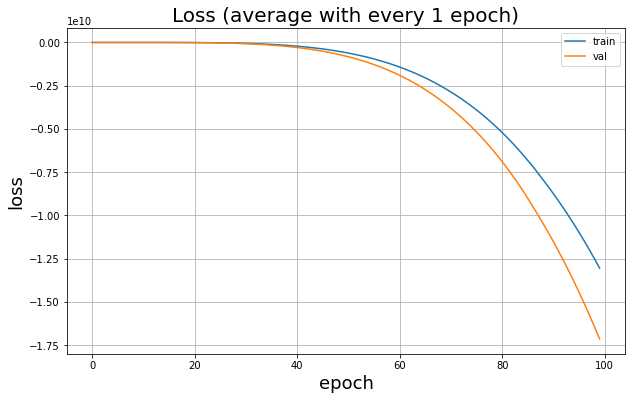

In [28]:
fig = plt.figure(figsize=(10,6))
acc = []
valAcc = []
step = 1
for i in range(len(history['loss'])//step):
  acc.append(np.mean(history['loss'][i:i+step:1]))
  valAcc.append(np.mean(history['val_loss'][i:i+step:1]))

plt.plot(acc)
plt.plot(valAcc)
plt.title('Loss (average with every {} epoch)'.format(step), fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.grid()
plt.legend(['train', 'val'], loc='upper right')

In [29]:
# from model.sdp import SDP 
# from service.distributeuavs import distributeUAVs
# from model.pathlossmodel import PathLossModel, NoiseMaker
# from service.combinationset import generateCombination
# UAVs = distributeUAVs()
# uavIndexes_withoutGPS = np.random.choice(env.N, env.N_ngps, replace=False)
# for id in uavIndexes_withoutGPS:
#   UAVs[id].observedPosition = None

# uavList_gps = []
# for id, uav in UAVs.items():
#   if not uav.observedPosition == None:
#     uavList_gps.append(id)

# print(uavList_gps)
# anomaly_index = np.random.choice(uavList_gps, 1, replace=False)[0]
# print(anomaly_index)

# originObservedPosition = UAVs[anomaly_index].observedPosition
# print(originObservedPosition)
# shift = np.random.choice(np.arange(500, 1000), 3, replace=False)
# print(shift)
# newObservedPosition = [originObservedPosition[0]+shift[0], originObservedPosition[1]+shift[1], originObservedPosition[2]+shift[2]]
# print(newObservedPosition)
# UAVs[anomaly_index].observedPosition = newObservedPosition
# pathLossModel = PathLossModel()
# pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = env.noiseDeviation)
# for i, uav_i in UAVs.items():
#   for j, uav_j in UAVs.items():
#     if not i == j:      
#       realDistance_ij = np.linalg.norm(np.array(uav_i.realPosition) - np.array(uav_j.realPosition))
#       rss = pathLossModel.estimateRSS(uav_i.power, realDistance_ij)
#       uav_i.collectRSS(j, rss)

# groupList = []
# for groupSize in range(env.DIMENSION+2, env.N_gps+1):
#   groupList.append(generateCombination(UAVs, groupSize))

# sdp = SDP()
# sdp.var_SOCPt = cp.Variable(1)
# sdp.var_SDPt = cp.Variable(1)
# sdp.var_p = [cp.Variable((env.DIMENSION+1, env.DIMENSION+1), symmetric=True) for i in range(env.N_ngps)]

# targets = []
# for uavIndex, uav in UAVs.items():
#   if uav.observedPosition is None:
#     targets.append(uav)

# results = []
# for groups in groupList:
#   for group in groups:
#     print(".", end='')
#     anchors = []
#     for i in group:
#       anchors.append(UAVs[i])

#     sdp.buildConstraint(targets, anchors, pathLossModel)
#     sdp.doSolve(log=False)
#     results.append([sdp.var_p[i].value[-1][:3] for i in range(env.N_ngps)])

# print(np.array(results).shape)
# sdpResult_uav = []
# for i in range(np.array(results).shape[1]):
#   temp = []
#   for j in range(np.array(results).shape[0]):
#     temp.append(results[j][i])
#   sdpResult_uav.append(temp)
# print(np.array(sdpResult_uav).shape)
# h = int (np.array(sdpResult_uav).shape[1])
# print(h)

# X = []
# for i in range(env.N_ngps):
#   temp = []
#   temp.append(sdpResult_uav[i][0 : h])
#   X.append(temp)
# print(np.array(X).shape)


# print(np.array(X).shape)

# new_X = []
# for i in range(np.array(X).shape[0]):
#   s = []
#   for j in range(np.array(X).shape[1]):
#     temp = []
#     for index_1, e1 in enumerate(X[i][j]):
#       for index_2, e2 in enumerate(X[i][j]):
#         if not index_1 == index_2:
#           temp.append([e1, e2])
#     s.append(temp)
#   new_X.append(s)

# X_reform = []
# rangeSample = range(np.array(new_X).shape[1])

# def swapFunc(j):
#   # print(j)
#   for sample in rangeSample:
#     temp = []
#     for i in range(np.array(X).shape[0]):
#       temp.append(new_X[i][sample][j])
#     X_reform.append(temp)

# nothing = list (map(lambda x: swapFunc(x), range(np.array(new_X).shape[2])))
# print(np.array(X_reform).shape)

# data = np.array(X_reform).reshape(len(X_reform), np.prod(np.array(X_reform).shape[1:]))
# data_min =0
# data_max = 1000
# anomaly_data = (data-data_min)/(data_max - data_min)

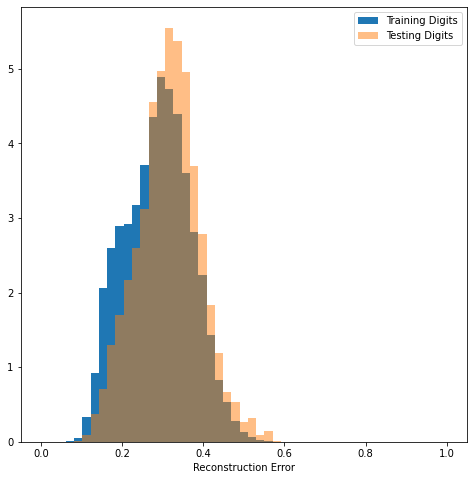

In [30]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), axis=1)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, 1, 50), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(y_train), bins = np.linspace(0, 1, 50), label = 'Testing Digits', density = True, alpha = 0.5)
# ax1.hist(model_mse(anomaly_data), bins = np.linspace(0, 1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

In [31]:
trainMean = np.mean(model_mse(X_train))
trainStd = np.std(model_mse(X_train))
# testMean = np.mean(model_mse(y_train))
# testStd = np.std(model_mse(y_train))
# anomalyMean = np.mean(model_mse(anomaly_data))
# anomalyStd = np.std(model_mse(anomaly_data))
print(trainMean,trainStd)
# print(trainStd,testStd)
# print(model_mse(X_train).shape)

0.28828636 0.08101123


In [32]:
# div 10
# 0.2586146 0.08263365

# div 20
# 0.23592666 0.05520087

# div 30
# 0.33629215 0.120262645

# div 40
# 0.23695469 0.06928754

# div 50
# 0.2801985 0.095142916

# div 60
# 0.35521522 0.10566868

# div 70
# 0.29245633 0.077471346

# div 80
# 0.29186997 0.08496217

# div 90
# 0.28829214 0.07185271

# div 100
# 0.2922152 0.09591793

# div 200
# 0.28828636 0.08101123

# div 300
# 0.2881503 0.0900476

# div 350
# 0.3333022 0.11985369